In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [89]:
from sklearn.datasets import make_classification
df_X, df_y = make_classification(n_samples=1000, n_features=8, n_informative=5,
n_redundant=2, random_state=42)
df = pd.DataFrame(df_X, columns=[f"feature_{i}" for i in range(8)])
df['target'] = df_y

# Drop duplicate rows
df = df.drop_duplicates()

In [73]:
# Check for duplicate values
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")



Number of duplicate rows: 0


In [74]:
# Check for null values
null_counts = df.isnull().sum()
print("\nNull values per column:")
print(null_counts)


Null values per column:
feature_0    0
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
target       0
dtype: int64


In [75]:
# Display the first few rows of the dataset
print("\nSample of the dataset:")
print(df.head())


Sample of the dataset:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.243847  -0.164471  -0.705182  -0.015433  -0.078425   0.730461   
1   0.650237   0.274936  -0.776536  -0.959132  -1.123291  -0.572504   
2  -3.390672  -0.590640  -1.343470   6.169133   1.222753   1.439649   
3   0.064793  -0.032960  -0.723131  -1.063065  -0.201072  -0.770711   
4   0.438060  -0.914989   0.953398  -0.033631  -0.048063  -0.860909   

   feature_6  feature_7  target  
0   0.363777   0.727296       0  
1  -0.918580   0.073886       0  
2  -1.715076   3.223089       1  
3   0.890636  -1.379626       1  
4   0.511169  -0.449294       0  


         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -0.011035    -0.492447    -0.042531     0.631419     0.480472   
std       1.618548     1.518933     1.042954     2.806143     1.583809   
min      -5.814203    -4.258034    -3.582063    -8.102614    -4.661168   
25%      -1.132212    -1.504082    -0.734871    -1.034635    -0.542215   
50%       0.029747    -0.760929    -0.030551     0.987519     0.583361   
75%       1.077206     0.230285     0.642444     2.371964     1.521656   
max       4.605669     5.685693     3.240139     7.933944     5.066061   

         feature_5    feature_6    feature_7       target  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      0.455850     0.499845     0.469059     0.502000  
std       2.000162     1.621358     1.489777     0.500246  
min      -7.298063    -4.341477    -3.889284     0.000000  
25%      -0.776099    -0.674893  

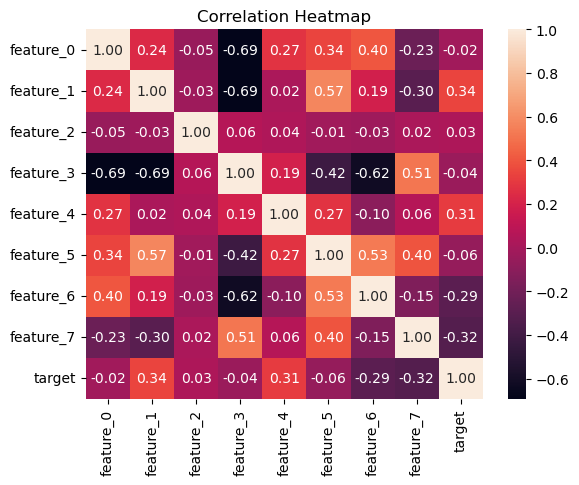

Features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'target']


In [76]:
print(df.describe())
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Show dataset feature names
print("Features:", df.columns.tolist())




In [77]:
from sklearn.preprocessing import PolynomialFeatures

# Add polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[[f"feature_{i}" for i in range(8)]])
poly_feature_names = poly.get_feature_names_out([f"feature_{i}" for i in range(8)])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# Concatenate polynomial features with target
df = pd.concat([df_poly, df['target'].reset_index(drop=True)], axis=1)

In [78]:
X = df.drop(columns=['target'])
y = df['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
def sigmoid(z):
    # Computes the sigmoid function
    return 1 / (1 + np.exp(-z))

def newton_raphson_logistic(X, y, iterations=500, reg_lambda=0.001):
    m, n = X.shape
    X = np.hstack((np.ones((m, 1)), X)) # Add intercept
    beta = np.zeros((n + 1, 1))
    y = y.values.reshape(-1, 1)

    for i in range(iterations):
        z = X @ beta
        p = sigmoid(z)
        W = np.diag((p * (1 - p)).flatten())
        H = X.T @ W @ X + reg_lambda * np.eye(n + 1) # Hessian with L2 regularization
        grad = X.T @ (y - p) - reg_lambda * beta # Gradient with L2 regularization
        try:
            H_inv = np.linalg.inv(H)
        except np.linalg.LinAlgError:
            print("Hessian is singular, using pseudo-inverse")
            H_inv = np.linalg.pinv(H)
        beta += H_inv @ grad
    return beta

In [81]:
beta = newton_raphson_logistic(pd.DataFrame(X_train_scaled), y_train, iterations=500, reg_lambda=0.001)

In [82]:
X_test_with_intercept = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))
y_pred_prob = sigmoid(X_test_with_intercept @ beta)
y_pred = (y_pred_prob >= 0.5).astype(int)

Accuracy: 92.00%
Confusion Matrix:
 [[90  5]
 [11 94]]


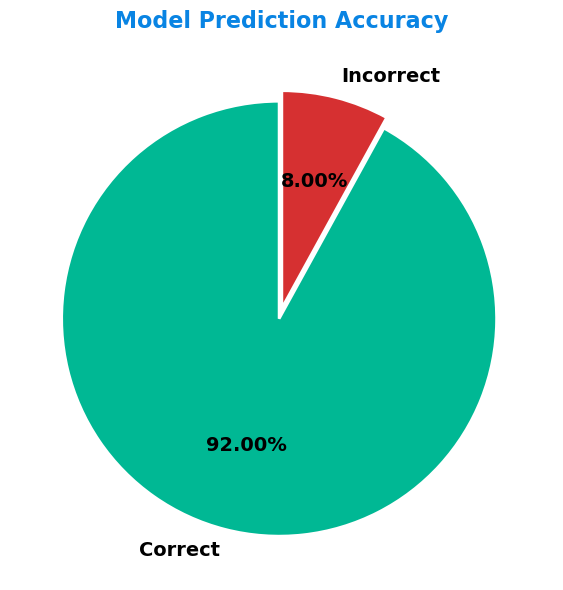

In [87]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
acc_percent = acc * 100
print(f"Accuracy: {acc_percent:.2f}%")
print("Confusion Matrix:\n", cm)

# Pie chart for accuracy vs error
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [acc_percent, 100 - acc_percent]
labels = ['Correct', 'Incorrect']
colors = ['#00b894', '#d63031']
explode = (0.05, 0)
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.2f%%', startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'}, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax.set_title('Model Prediction Accuracy', fontsize=16, fontweight='bold', color='#0984e3')
plt.tight_layout()
plt.show()

In [86]:
# Compare with scikit-learn's LogisticRegression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Scikit-learn LogisticRegression Accuracy: {acc_lr*100:.2f}%")

Scikit-learn LogisticRegression Accuracy: 93.50%
